In [1]:
from astropy import units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS
from astropy.coordinates import SkyCoord
from astropy.table import QTable, unique
from astropy.time import Time
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.patches import Circle
import numpy as np
import plot_utils as pu
import os
from astropy.io import fits
from spectral_cube import Projection
from scipy.special import jv

bessel = lambda x: jv(1, x)

backgroundcolour = "#171726"
foregroundcolour = "#FFF"

cmap = LinearSegmentedColormap.from_list("sky", [backgroundcolour, foregroundcolour])

Simbad.reset_votable_fields()

generic_maximum_magnitude = 10

directory = "/home/taiwithers/projects/skysim/mvp/VXYLyr_2"

In [2]:
def rewrite(fname, new_fname):
    data, header = fits.getdata(
        f"{directory}/{fname}", header=True, ignore_missing_simple=True
    )
    new_rheader = header.copy()
    fits.writeto(f"{directory}/{new_fname}", data, new_rheader, overwrite=True)


for fname in os.listdir(directory):
    if "Zone" not in fname:
        rewrite(fname, f"{fname[:-5]}_simple.fits")

In [3]:
r = Projection.from_hdu(fits.open(f"{directory}/2ir_simple.fits"))
g = Projection.from_hdu(fits.open(f"{directory}/2red_simple.fits"))
b = Projection.from_hdu(fits.open(f"{directory}/2blue_simple.fits"))

g = g.reproject(r.header)
b = b.reproject(r.header)


image = []
for i in [r, g, b]:
    i = i.astype(float)
    i -= np.nanmin(i)
    i /= np.nanmax(i)

    image.append(i)
image = np.array(image).T

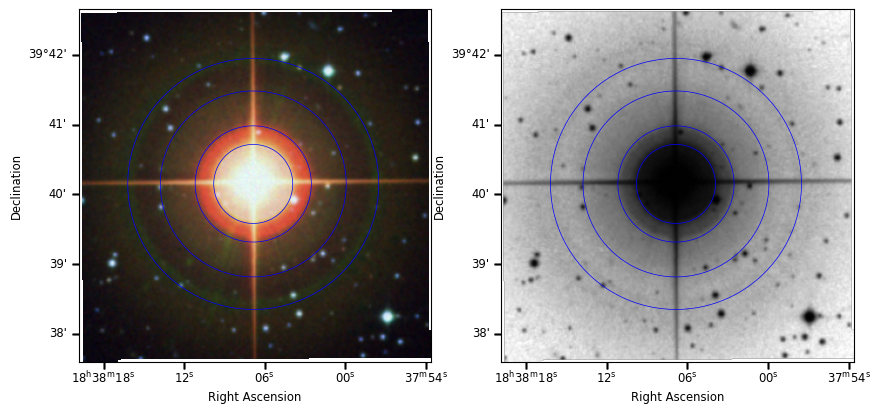

Airy disk first minimum: 42.0 arcsec


In [29]:
wcs = WCS(r.header)
fig, ax = pu.fig_setup(figsize=(10, 6), wcs=wcs, fig_kwargs={"ncols": 2})
ax[0].imshow(image)

greyscale = np.sum(image * [1 / 3, 1 / 3, 1 / 3], axis=-1)
vmin, vmax = pu.get_percentiles(greyscale, coverage=99.9)
norm = LogNorm(vmin=vmin, vmax=vmax)
ax[1].imshow(greyscale, cmap="Greys", norm=norm)

maxima = [34, 50, 80, 108]
for radius in maxima:
    for a in ax:
        c = SphericalCircle(
            SkyCoord(ra="18h38m6.85s", dec="39d40m9s"),
            radius * u.arcsec,
            edgecolor="b",
            facecolor="none",
            lw=0.5,
            transform=a.get_transform("world"),
        )
        a.add_patch(c)

for a in ax:
    pu.style_wcs_axes(a)
# pu.style_wcs_axes(ax[1])
plt.show()

first_minimum = (maxima[1] + maxima[0]) / 2 * u.arcsec
print(f"Airy disk first minimum: {first_minimum}")

\begin{gather}
I(\theta) = I_0 \left( \frac{2J_1(x)}{x} \right)^2\\
x = ka \sin(\theta) = ka \theta\\
k = \frac{2\pi}{\lambda}
\end{gather}

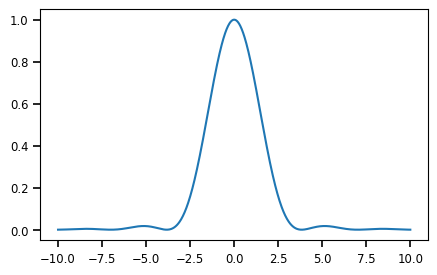

0.0009191197963556955 arcsec


In [27]:
theta = np.linspace(-10, 10, 1000)
wavelength = 550 * u.nm
aperture_radius = 4 * u.mm
maximum_intensity = 1

wavenumber = 2 * np.pi / wavelength


def intensity(theta):
    # x = wavenumber * aperture_radius * np.sin(theta)
    x = theta
    # x = np.sin(theta)
    return maximum_intensity * (2 * bessel(x) / x) ** 2


fig, ax = pu.fig_setup(figsize=(5, 3))
ax.plot(theta, intensity(theta))
plt.show()

airy_angle = (first_minimum / (wavenumber * aperture_radius)).to(u.arcsec)
print(airy_angle)